## Load the modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=25)

import numpy as np
import astropy
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
from pathlib import Path
import regions
from regions import CircleSkyRegion, PointSkyRegion

#import pickle
#import glob

## Load the gammapy modules

In [2]:
import gammapy
import gammapy.irf as irf
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation, Observations, DataStore
#from gammapy.utils.random import get_random_state
from gammapy.maps import MapAxis, WcsGeom, Map, RegionGeom
from gammapy.makers import SafeMaskMaker, MapDatasetMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, WobbleRegionsFinder
from gammapy.estimators import FluxPointsEstimator

# models modules
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    FoVBackgroundModel,
    SpectralModel,
    #Parameter, 
    TemplateSpectralModel
)
# dataset modules
from gammapy.datasets import (
    MapDataset, 
    MapDatasetOnOff, 
    MapDatasetEventSampler,
    SpectrumDatasetOnOff,
    SpectrumDataset, 
    Datasets,
    FluxPointsDataset
)

### Check the versions of the packages

In [3]:
print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)

gammapy: 0.20
numpy: 1.23.2
astropy 5.1
regions 0.6


## Load the DL3 data

In [36]:
#datastore = DataStore.from_dir(f"../../arqus/data/crab_nebula/magic/")
#obs_ids = [5029747, 5029748]

datastore = DataStore.from_dir(f"../1_read_data/data_test/")
obs_ids = [5029747]

#NOT WORKING FOR THE CASE OF THE POINT-LIKE, GETTING AN ERROR WHEN CREATING THE DATASETS. 
observations_crab = datastore.get_observations(obs_ids, required_irf='point-like')

# THIS IS A LIND FROM THE GAMMAPY NOTEBOOKS, THE DATA SEEMS TO BE THE SAME, BUT ALSO NOT WORKING, NO DATA LOADED
observations_crab = datastore.get_observations(
    required_irf=["aeff", "edisp"]
)

### Task 1: Print the observations

In [40]:
observations_crab.ids

['5029747', '5029748']

In [41]:
# %load ./Solutions/print_crab.py
print(observations_crab)


Observations
Number of observations: 2
Observation

	obs id            : 5029747 
 	tstart            : 56569.18
	tstop             : 56569.19
	duration          : 1188.00 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 0.6%
Observation

	obs id            : 5029748 
 	tstart            : 56569.20
	tstop             : 56569.21
	duration          : 1184.00 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 0.6%



### Task 2:  Check RA and DEC coordinates for Crab Nebula to define the region of interest (ROI)

In [42]:
# %load ./Solutions/coord.py
SkyCoord.from_name("Crab Nebula")


<SkyCoord (ICRS): (ra, dec) in deg
    (83.6333, 22.0133)>

## Define the Circle sky region around our source

In [211]:
target_position = SkyCoord(ra=83.63, dec=22.0145, unit="deg", frame="icrs")

theta = observations_crab[0].aeff.meta['RAD_MAX']
assert all(o.aeff.meta['RAD_MAX'] == theta for o in observations_crab)

on_region_radius = Angle(theta*u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

skydir = target_position.galactic

In order to take into account possible sources around the Crab Nebula, we need to create an exclusion mask.

### Task 3: Using the webpage http://gamma-sky.net/ find if there is a known gamma-ray source near Crab Nebula, and if there is one, its coordinates.

# %load ./Solutions/exclusion_region.py
In the vicinity of  Crab Nebula, there is only one known gamma-ray source, the AGN called RGB J0521+212 with galactic coordinates GLON = 183.604 deg and GLAT = -8.708 deg.


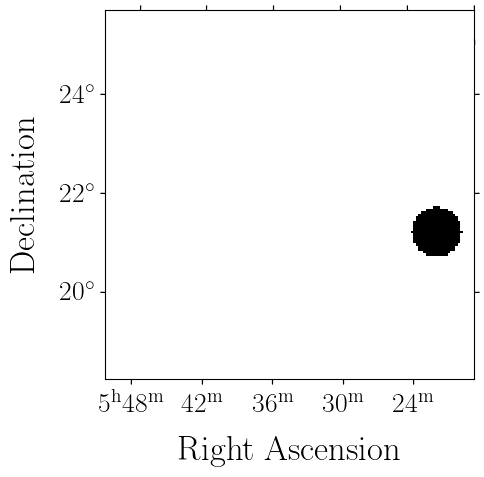

In [175]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5* u.deg,
)
skydir = target_position.galactic
geom =  WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot();

### Create the Datasets - data reduction chain

In [167]:
energy_axis = MapAxis.from_energy_bounds(
    0.03204001, 6.185958, nbin=12, per_decade=False, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
   0.03204001, 6.185958, nbin=12, per_decade=False, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(
    energy_axis_true=energy_axis_true, geom=geom
)


In [324]:
dataset_maker = SpectrumDatasetMaker(
     selection=["counts", "exposure"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask, 
                                            min_distance="45 deg",
                                            min_distance_input="5 deg",
                                           max_region_number=3)

safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=5)

In [325]:
%%time
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations_crab):

    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

CPU times: user 150 ms, sys: 4.71 ms, total: 155 ms
Wall time: 154 ms


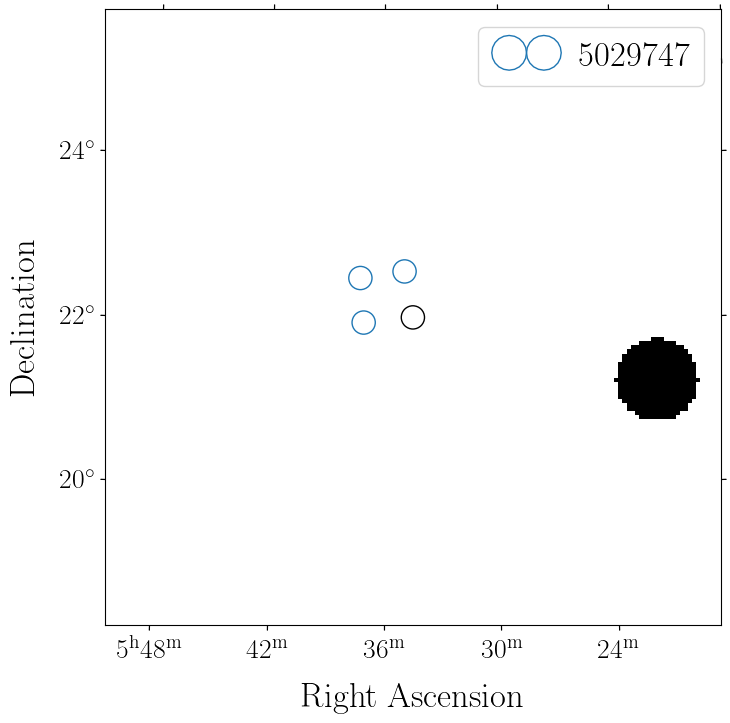

In [326]:
plt.figure(figsize=(8, 8) )
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

### We can see that the spectrum datasets contains all the ingredients for the likelihood calculation

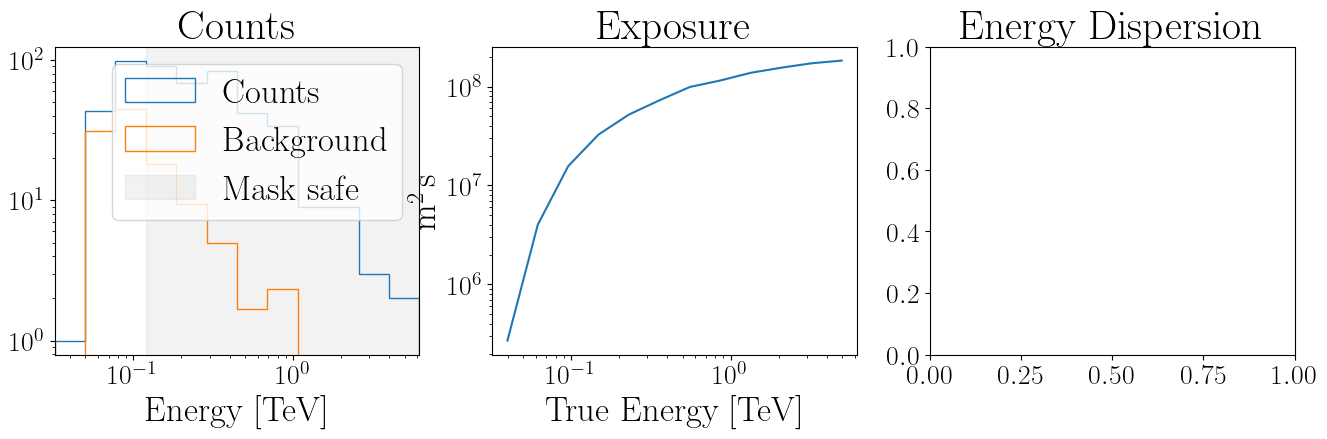

In [327]:
datasets[0].peek()

### Plot the off regions

## Define the spectral model and run the fit

In [328]:
spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    lambda_=0.1 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)
model = SkyModel(spectral_model=spectral_model, name="crab")

datasets.models = [model]

fit = Fit()
result = fit.run(datasets=datasets)

#### Plot the results and the parameters of the fit

In [329]:
print(result)
datasets.models.to_parameters_table()
print(result.total_stat)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 255
	total stat : 13.31

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

13.306510493916278


## Compute the flux points

We can compute flux points by fitting the norm of the global model in energy bands. We’ll use a fixed energy binning for now:

In [330]:
e_min, e_max = 0.7, 30
energy_edges = np.geomspace(e_min, e_max, 11) * u.TeV

In [331]:
energy_edges= np.array( [ 0.03204001, 0.04967855, 0.07702737, 0.11943215, 0.18518144,
       0.28712675, 0.44519454, 0.69028115, 1.0702919 , 1.6595044 ,
       2.5730877 , 3.989613 , 6.185958]) * u.TeV

In [333]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="crab", selection_optional="all"
)
flux_points_crab = fpe.run(datasets=datasets[0])

ValueError: non-broadcastable output operand with shape (1,1,1) doesn't match the broadcast shape (12,1,1)

Print the table of the resulting flux points: 

In [149]:
flux_points_crab.to_table(sed_type="dnde", formatted=True)

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.040,0.032,0.050,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.062,0.050,0.077,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.096,0.077,0.119,7.510e-09,1.319e-09,1.360e-09,1.280e-09,1.032e-08,49.501,7.036,98.98582114515939,58.270702,0.000,False,99.0,True,0.200 .. 5.000,28.355 .. 233.030
0.149,0.119,0.185,3.096e-09,4.226e-10,4.372e-10,4.091e-10,4.003e-09,106.086,10.300,90.92081149558639,70.91832,0.000,False,91.0,True,0.200 .. 5.000,55.684 .. 330.161
0.231,0.185,0.287,1.177e-09,1.604e-10,1.668e-10,1.542e-10,1.524e-09,134.094,11.580,68.99984255103097,61.428413,0.000,False,69.0,True,0.200 .. 5.000,60.894 .. 341.880
0.358,0.287,0.445,7.073e-10,8.153e-11,8.452e-11,7.861e-11,8.824e-10,232.366,15.244,82.99749874295631,79.283195,0.000,False,83.0,True,0.200 .. 5.000,131.280 .. 217.787
0.554,0.445,0.690,1.712e-10,2.742e-11,2.883e-11,2.604e-11,2.318e-10,126.430,11.244,41.99975617170776,40.571182,0.000,False,42.0,True,0.200 .. 5.000,49.546 .. 242.679
0.860,0.690,1.070,7.294e-11,1.322e-11,1.398e-11,1.249e-11,1.025e-10,91.802,9.581,33.99988947408401,32.285603,0.000,False,34.0,True,0.200 .. 5.000,44.463 .. 136.764


Plot the points:

<AxesSubplot:xlabel='Energy [TeV]', ylabel='e2dnde (erg / (cm2 s))'>

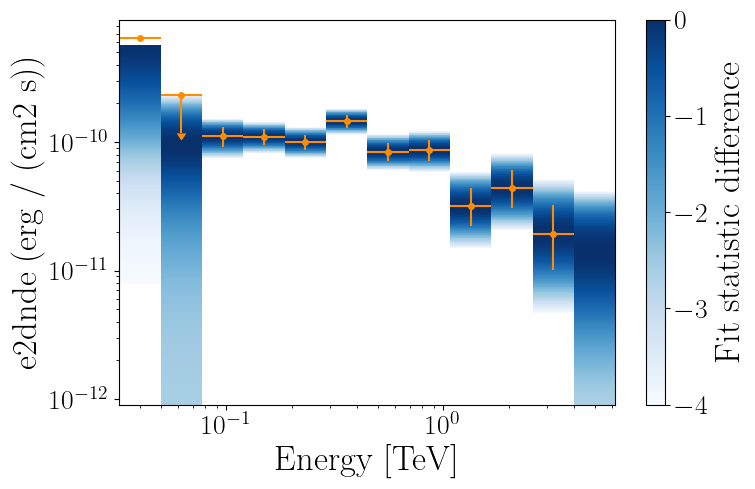

In [101]:
plt.figure(figsize=(8, 5))
ax = flux_points_crab.plot(sed_type="e2dnde", color="darkorange")
flux_points_crab.plot_ts_profiles(ax=ax, sed_type="e2dnde")

Plot the resulting fit, together with the points: 

(<AxesSubplot:xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals\n (data - model) / model'>)

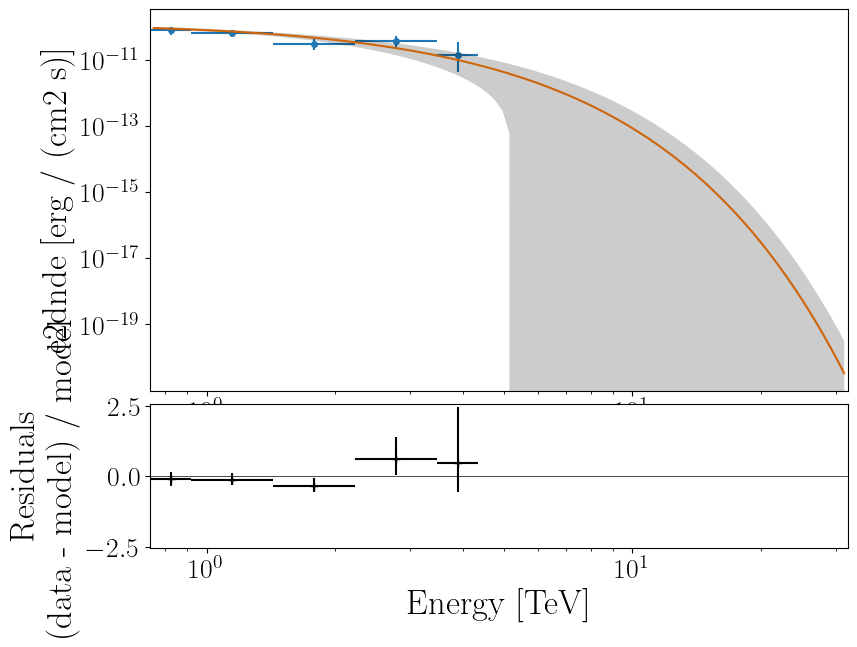

In [65]:
flux_points_crab_dataset = FluxPointsDataset(
    data=flux_points_crab, models=datasets.models
)
flux_points_crab_dataset.plot_fit()

### Task 4: Define the Power law spectral model, using the PowerLawSpectralModel module with the default parameters, fit the dataset and print the results

In [66]:
# %load ./Solutions/pwl_model.py
spectral_model_pwl = PowerLawSpectralModel(
)
model_pwl = SkyModel(spectral_model=spectral_model, name="crab_pwl")

datasets.models = [model_pwl]

fit = Fit()
result_pwl = fit.run(datasets=datasets)

datasets.models.to_parameters_table()
print(result_pwl)
print(result_pwl.total_stat)


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 42
	total stat : 18.75

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

18.74924509572608


### Task 5: Compute the flux points changing the energy range (100 GeV - 10 TeV) and number of bins (15).

In [67]:
# %load ./Solutions/pwl_model_points.py
e_min, e_max = 0.1, 10
energy_edges = np.geomspace(e_min, e_max, 16) * u.TeV

fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="crab", selection_optional="all"
)
flux_points_crab_pwl = fpe.run(datasets=datasets)

flux_points_pwl.to_table(sed_type="dnde", formatted=True)

plt.figure(figsize=(8, 5))
ax = flux_points.plot(sed_type="e2dnde", color="darkorange")
flux_points_pwl.plot_ts_profiles(ax=ax, sed_type="e2dnde")


ValueError: 'crab' is not in list

### Task 6: Plot the new pwl fit and the flux points.

In [323]:
# %load ./Solutions/pwl_model_points_plot.py
flux_points_crab_dataset_pwl = FluxPointsDataset(
    data=flux_points_crab_pwl, models=datasets.models
)
flux_points_crab_dataset_pwl.plot_fit()


NameError: name 'flux_points_crab_pwl' is not defined